In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/MyDrive/shape_alpha/rakshak_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: generated_data/shapes/trapezoid/trapezoid_C_0.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_1.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_10.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_11.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_12.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_13.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_14.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_15.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_16.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_17.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_18.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_19.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_2.jpg  
  inflating: generated_data/shapes/trapezoid/trapezoid_C_20.jpg  
  inflating: generated_data/

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [5]:
directory = '/content/generated_data/letters'
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 23400 files belonging to 26 classes.


In [7]:
class_names = dataset.class_names
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

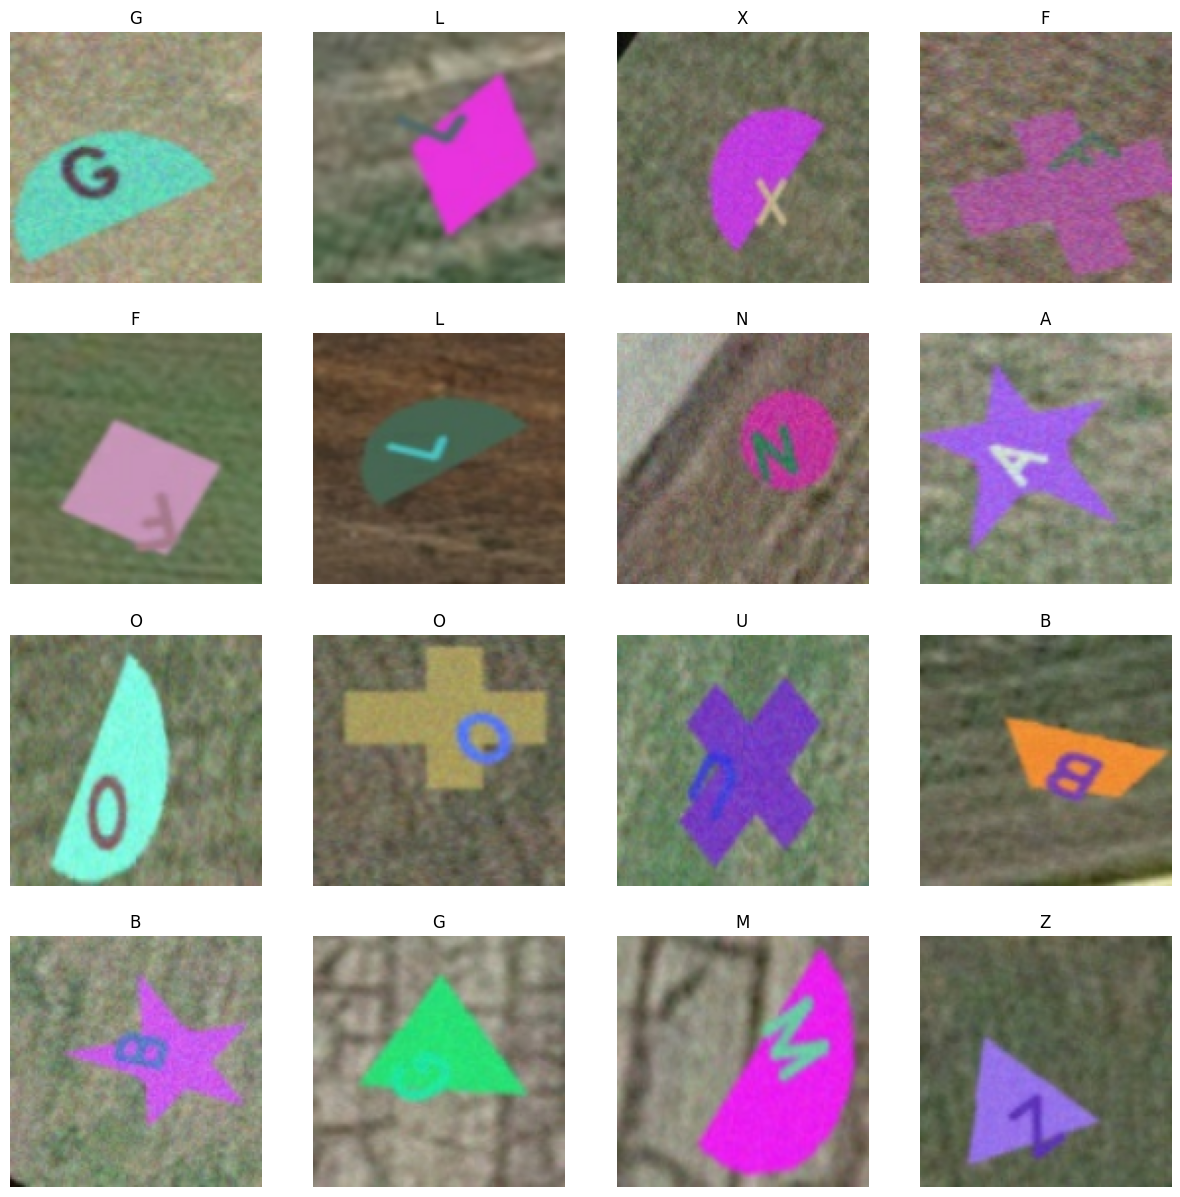

In [8]:
plt.figure(figsize=(15,15))

for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
import os
import shutil
import random

# Set the source directory containing the 26 class folders (A, B, C, ..., Z)
source_directory = '/content/generated_data/letters'

# Set the destination directories for train, test, and validation data
train_directory = '/content/train_L'
test_directory = '/content/test_L'
validation_directory = '/content/val_L'

# Create 26 subdirectories for each class in the train, test, and validation directories
classes = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
for letter in classes:
    os.makedirs(os.path.join(train_directory, letter), exist_ok=True)
    os.makedirs(os.path.join(test_directory, letter), exist_ok=True)
    os.makedirs(os.path.join(validation_directory, letter), exist_ok=True)

# Split ratio (adjust as needed)
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

# Loop through each class folder and split the images randomly into train, test, and validation sets
for letter in classes:
    class_directory = os.path.join(source_directory, letter)
    filenames = os.listdir(class_directory)
    random.shuffle(filenames)

    train_size = int(train_ratio * len(filenames))
    test_size = int(test_ratio * len(filenames))

    train_files = filenames[:train_size]
    test_files = filenames[train_size:train_size + test_size]
    validation_files = filenames[train_size + test_size:]

    for file in train_files:
        src = os.path.join(class_directory, file)
        dst = os.path.join(train_directory, letter, file)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_directory, file)
        dst = os.path.join(test_directory, letter, file)
        shutil.copy(src, dst)

    for file in validation_files:
        src = os.path.join(class_directory, file)
        dst = os.path.join(validation_directory, letter, file)
        shutil.copy(src, dst)


In [10]:
import cv2
# Custom preprocessing function to convert the image to grayscale
def grayscale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.expand_dims(gray_image, axis=-1)
    return gray_image

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=grayscale,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    #zoom_range=0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'

)

train_generator = train_datagen.flow_from_directory(
    '/content/train_L',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 18720 images belonging to 26 classes.


In [12]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=grayscale,
)

test_generator = test_datagen.flow_from_directory(
    '/content/test_L',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 2340 images belonging to 26 classes.


In [13]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=grayscale,
)

val_generator = val_datagen.flow_from_directory(
    '/content/val_L',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 2340 images belonging to 26 classes.


# Using Transfer Learning from the DenseNet201 Model

In [14]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 26

dense_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

74836368/74836368 [==============================] - 3s 0us/step


In [15]:
for layer in dense_model.layers[:675]:
    layer.trainable = False


for layer in dense_model.layers[675:]:
    layer.trainable = True

In [16]:
for i, layer in enumerate(dense_model.layers):
    print(i, layer.name, '-', layer.trainable)

0 input_1 - False
1 zero_padding2d - False
2 conv1/conv - False
3 conv1/bn - False
4 conv1/relu - False
5 zero_padding2d_1 - False
6 pool1 - False
7 conv2_block1_0_bn - False
8 conv2_block1_0_relu - False
9 conv2_block1_1_conv - False
10 conv2_block1_1_bn - False
11 conv2_block1_1_relu - False
12 conv2_block1_2_conv - False
13 conv2_block1_concat - False
14 conv2_block2_0_bn - False
15 conv2_block2_0_relu - False
16 conv2_block2_1_conv - False
17 conv2_block2_1_bn - False
18 conv2_block2_1_relu - False
19 conv2_block2_2_conv - False
20 conv2_block2_concat - False
21 conv2_block3_0_bn - False
22 conv2_block3_0_relu - False
23 conv2_block3_1_conv - False
24 conv2_block3_1_bn - False
25 conv2_block3_1_relu - False
26 conv2_block3_2_conv - False
27 conv2_block3_concat - False
28 conv2_block4_0_bn - False
29 conv2_block4_0_relu - False
30 conv2_block4_1_conv - False
31 conv2_block4_1_bn - False
32 conv2_block4_1_relu - False
33 conv2_block4_2_conv - False
34 conv2_block4_concat - False
35 c

In [17]:
model = tf.keras.models.Sequential()
model.add(dense_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 26)                49946     
                                                                 
Total params: 18,371,930
Trainable params: 1,195,930
Non-trainable params: 17,176,000
_________________________________________________________________


In [19]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=['accuracy']
)


# Early Stopping

In [20]:
filepath = 'model_letter.h5'
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=True,
    mode='max',
    save_weights_only = False
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.0001
)

callbacks_list = [
    checkpoint,
    early_stopping,
    learning_rate_reduction
]

In [21]:
history = model.fit(
        train_generator,
    steps_per_epoch=147,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=19,
    verbose = 1,
    epochs = 20,
    callbacks=callbacks_list
)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 2.9497 - accuracy: 0.1482
Epoch 1: val_accuracy improved from -inf to 0.20066, saving model to model_letter.h5
147/147 [==============================] - 62s 235ms/step - loss: 2.9497 - accuracy: 0.1482 - val_loss: 2.7035 - val_accuracy: 0.2007 - lr: 0.0010
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 2.3742 - accuracy: 0.2655
Epoch 2: val_accuracy improved from 0.20066 to 0.33553, saving model to model_letter.h5
147/147 [==============================] - 31s 208ms/step - loss: 2.3742 - accuracy: 0.2655 - val_loss: 2.2866 - val_accuracy: 0.3355 - lr: 0.0010
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 2.1960 - accuracy: 0.3219
Epoch 3: val_accuracy did not improve from 0.33553
147/147 [==============================] - 30s 203ms/step - loss: 2.1960 - accuracy: 0.3219 - val_loss: 2.1604 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 4/20
147/147 [===========================

In [22]:


scores = model.evaluate(test_generator)

74/74 [==============================] - 6s 82ms/step - loss: 1.6526 - accuracy: 0.4910


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

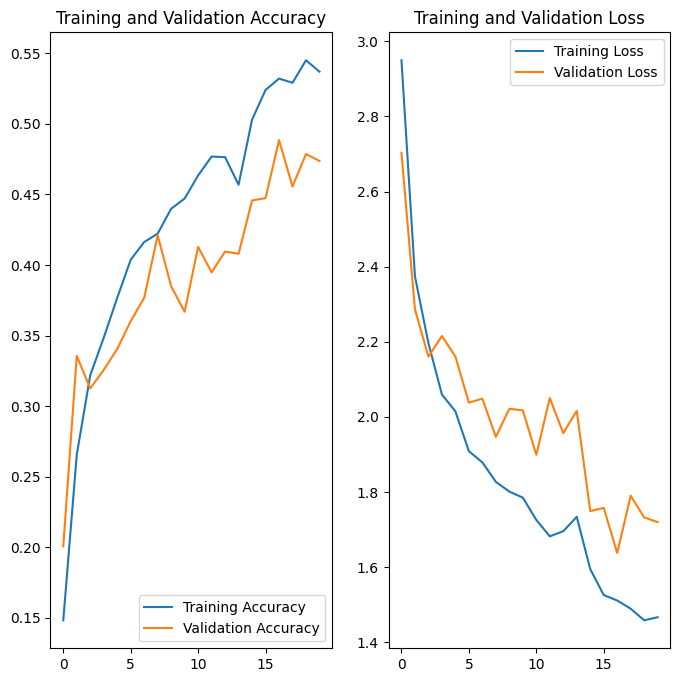

In [24]:
#Plotting the history of the model training

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
y_pred = model.predict(test_generator)
pred = np.argmax(y_pred,axis=1)
print(pred)

74/74 [==============================] - 7s 54ms/step
[ 6  2 18 ...  0  7 20]


# Checking results for random images from the test set

image to predict
Actual Label:  L
1/1 [==============================] - 0s 40ms/step
Predicted Label:  L


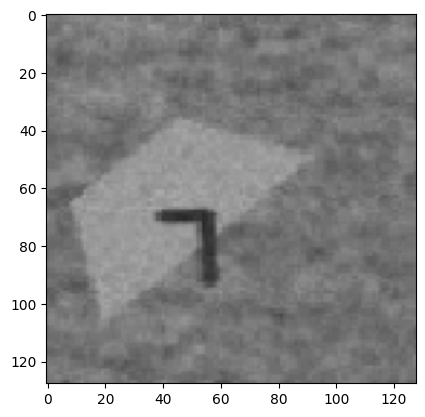

In [27]:
i = 4
for images_batch, labels_batch in test_generator:
    first_image = images_batch[0]
    first_label = int(labels_batch[0])

    print("image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])
    break